In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.linalg import block_diag
import statsmodels.api as sm
import matplotlib.ticker as mtick
from tqdm.notebook import tqdm
from utils import HMM, regime_betas

fldr = os.path.abspath(os.path.join(os.getcwd(), '..'))
trn_start_dt = datetime(1926, 12, 31)  # Training start
bt_start_dt = datetime(2002, 12, 31)  # Backtest start
bt_end_dt = datetime(2019, 3, 31)  # Backtest end

In [2]:
# Fama-French factors
rt_ff = pd.read_pickle(f'{fldr}/data/ff.pkl')
rf = rt_ff['rf']
rt_ff.drop(['rf', 'umd'], axis=1, inplace=True)

# Stock returns
rt = pd.read_pickle(f'{fldr}/data/rt_sp.pkl')
er = rt.sub(rf, axis=0).dropna(how='all')  # Excess return

# S&P meta data
is_tradable = pd.read_pickle(f'{fldr}/data/is_tradable_sp.pkl')
meta = pd.read_pickle(f'{fldr}/data/meta_sp.pkl')

For the sake of this exercise I'm using a static insample regime modeling. I will compar later how this compares with an out-of-sample exercise.

Model is not converging.  Current: 275156.4063083836 is not greater than 275158.1422257228. Delta is -1.7359173391596414
Model is not converging.  Current: 278329.26878041343 is not greater than 278329.6649689195. Delta is -0.39618850604165345
Model is not converging.  Current: 278086.1361196701 is not greater than 278088.7130941936. Delta is -2.5769745234865695
Model is not converging.  Current: 278892.7716932633 is not greater than 278895.083186168. Delta is -2.311492904671468


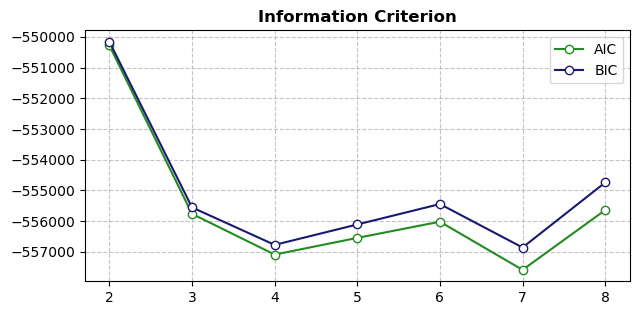

State-dependent means                   \
                             mktrf      smb     hml   
Hidden State                                          
0                           13.99%    7.07%   4.51%   
1                          -20.43%   -6.47%  14.13%   
2                          -17.01%  -12.56%   5.83%   
3                           17.95%    5.23%   1.35%   

             State-dependent volatilities                  
                                    mktrf     smb     hml  
Hidden State                                               
0                                  12.60%   7.17%   8.67%  
1                                  43.14%  24.96%  24.81%  
2                                  19.82%  10.11%   9.61%  
3                                   8.64%   4.95%   4.63%


Transition Matrix


,0,1,2,3
Hidden State,,,,
0,96.63%,1.31%,0.07%,1.99%
1,4.04%,91.90%,4.05%,0.00%
2,0.13%,1.52%,89.23%,9.12%
3,0.84%,0.02%,3.57%,95.57%


In [3]:
trn = rt_ff.loc[trn_start_dt:bt_end_dt]  # Training set

states_to_try = range(2, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)

for n in states_to_try:
    mdl = HMM(n_states=n, diag=True)
    mdl.fit(trn)
    bic[n] = mdl.bic
    aic[n] = mdl.aic

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.5, 3.25), sharex=True, sharey=False)
plot_map = {'AIC': (aic, 'forestgreen'), 'BIC': (bic, 'midnightblue')}

for i, label in enumerate(plot_map):
    ax.plot(plot_map[label][0], color=plot_map[label][1], marker='o', mfc='white')
    ax.grid(ls='--', alpha=.75)

ax.set_title('Information Criterion', weight='bold')
ax.legend(['AIC', 'BIC'])
plt.tight_layout()
plt.show()

m = 4
mdl = HMM(n_states=m)
mdl.fit(trn)

# Results tables
cols = pd.MultiIndex.from_tuples([('State-dependent means', x) for x in trn.columns])
table_means = pd.DataFrame(mdl.mu, columns=cols)
table_means.index.name = 'Hidden State'
cols = pd.MultiIndex.from_tuples([('State-dependent volatilities', x) for x in trn.columns])
table_vols = pd.DataFrame([np.diag(mdl.sigma[i]) for i in range(m)], columns=cols).apply(np.sqrt)
table_vols.index.name = 'Hidden State'
table = pd.concat([table_means.mul(252), table_vols.mul(np.sqrt(252))], axis=1)
display(table.apply(lambda x: x.map('{:.2%}'.format)))

print('\nTransition Matrix')
df = pd.DataFrame(mdl.transition_matrix, columns=range(m))
df.index.name = 'Hidden State'
display(df.apply(lambda x: x.map('{:.2%}'.format)))

Whole sample estimates for now

In [193]:
rebalance_dts = pd.date_range(start=bt_start_dt, end=bt_end_dt, freq='BM')
k = rt_ff.shape[1]

'''
Using whole sample for now.
Memory is crashing with the math operations since 1926 (on top of being slow), so I'm trimming the sample and starting in 1980s
'''

fetch_theta = {}
subset = is_tradable.columns[is_tradable[bt_start_dt:].any()]
sample = er.loc['1980':bt_end_dt, subset]  # Whole sample for now
for sec_id in tqdm(sample.columns[:5], ):  # <--- 10 for now
    fetch_theta[sec_id] = regime_betas(exog=sample[sec_id].dropna(), endog=rt_ff, emission_prob=mdl.emission_prob)

  0%|          | 0/5 [00:00<?, ?it/s]

In [209]:
collect_betas = {}
collect_mu = {}
B = mdl.transition_matrix
for sec_id in tqdm(sample.columns[:5]):
    for dt in rebalance_dts:
        h = 20  # <--- Should be the number of days to the next rebalance
        B_h = np.linalg.matrix_power(B, h)
        Theta = fetch_theta[sec_id]
        g = mdl.emission_prob.asof(dt).values.reshape(-1, 1)
        exp_beta = Theta @ B_h.T @ g
        collect_betas[(dt, sec_id)] = pd.Series(exp_beta.flatten())

        b = exp_beta[1:]
        g = mdl.emission_prob.asof(dt).values.reshape(-1, 1)
        mu_it = (g.T @ B_h @ mdl.mu @ b).item() + exp_beta[0]
        collect_mu[(dt, sec_id)] = mu_it.item()

betas = pd.DataFrame.from_dict(collect_betas, orient='index').sort_index()
betas.index.names = ['Date', 'Id']
betas.columns = ['const'] + list(rt_ff.columns)

mu = pd.Series(collect_mu).sort_index()

  0%|          | 0/5 [00:00<?, ?it/s]

### Weighting covariance matrices

Given $\mathcal{F}_{t}$, let

1. $\gamma_{t} \in \mathbb{R}^{1 \times 4}$ be the emission probabilities for each one of the $4$ hidden states, on date $t$
1. $\gamma_{t} \mathbf{1}_{n} = 1$
1. $\Sigma_{s} \in \mathbb{R}^{3 \times 3}$ be the covariance matrix of the $3$ factors (MktRf, SmB, HmL) that correspond to state $s$ (there are 4 of these)
1. $\hat{\Sigma}_{s, t}$ is the "expected" covariance matrix resulting of combining the 4 covariance matrices using the emission probabilities in $\gamma_{t}$

(This is what I'm doing)

\begin{align}
    \hat{\Sigma}_{s, t} = \gamma_{t, \left( s=1 \right)} \Sigma_{s, \left( s=1 \right)} + \gamma_{t, \left( s=2 \right)} \Sigma_{s, \left( s=2 \right)} + \dots \gamma_{t, \left(s=4\right)} \Sigma_{s, \left( s=4 \right)}
\end{align}

In [228]:
S_t = np.zeros((k, k))
for i in range(m):
    S_t += g[i] * mdl.sigma[i]

S = S_t
D = np.diag(np.sqrt(np.diag(S)))
print(pd.DataFrame(np.linalg.inv(D) @ S @ np.linalg.inv(D)))
print('\n')

          0         1         2
0  1.000000 -0.173760 -0.318822
1 -0.173760  1.000000 -0.014285
2 -0.318822 -0.014285  1.000000




In [227]:
for i in range(4):
    S = mdl.sigma[i]
    D = np.diag(np.sqrt(np.diag(S)))
    print(pd.DataFrame(np.linalg.inv(D) @ S @ np.linalg.inv(D)))
    print('\n')

          0         1         2
0  1.000000  0.350774  0.605761
1  0.350774  1.000000  0.154395
2  0.605761  0.154395  1.000000


          0         1         2
0  1.000000 -0.230072  0.454417
1 -0.230072  1.000000 -0.120025
2  0.454417 -0.120025  1.000000


          0         1         2
0  1.000000 -0.166631 -0.415238
1 -0.166631  1.000000 -0.039042
2 -0.415238 -0.039042  1.000000


          0         1         2
0  1.000000 -0.290524 -0.138182
1 -0.290524  1.000000  0.073485
2 -0.138182  0.073485  1.000000




### Projecting from factor space into asset space

Let

1. $\Sigma_{F} \in \mathbb{R}^{3 \times 3}$ be the factor covariance matrix of the $3$ factors (MktRf, SmB, HmL) 
1. $\Theta \in \mathbb{R}^{n \times 3}$ the matrix of betas of the $n$ assets to the three factors
1. $\hat{\Sigma} \in \mathbb{R}^{n \times n}$ the projected covariance matrix of the $n$ assets 

(This is what I'm doing)

\begin{align}
    \hat{\Sigma} = \Theta \Sigma_{F} \Theta^{T}
\end{align}

In [217]:
B_t = betas.xs(dt).drop('const', axis=1).values
S = B_t @ S_t @ B_t.T
D = np.diag(np.sqrt(np.diag(S)))
print(pd.DataFrame(np.linalg.inv(D) @ S @ np.linalg.inv(D)))

          0         1         2         3         4
0  1.000000  0.998507  0.976927  0.894047  0.690059
1  0.998507  1.000000  0.980615  0.906275  0.726779
2  0.976927  0.980615  1.000000  0.825343  0.698026
3  0.894047  0.906275  0.825343  1.000000  0.868719
4  0.690059  0.726779  0.698026  0.868719  1.000000
